In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import os
import glob
import itertools

%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):


In [3]:
#first get shuffled population
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
fpf.generate_shuffle_population(mice=mice, proj_folder= "/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq", total_number_shuffles= 100000, mice_sep=True, use_slurm=False)


collate_all_shuffles= 15894059


In [92]:
#fpf.collate_all_shuffles(temp_shuffle_folder='/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/temp_shuffles', mice_sep=False, mice=['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d'], overwrite=False, use_slurm=False, )

In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, binary=True, IT_only=True, area_threshold=0.1)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, binary=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False, binary=True,  IT_only=True)
    new_dict['shuff_cubelet']= fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=True, IT_only=True)
    new_dict['shuff_area']=fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=False,  IT_only=True)
    new_dict['shuff_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, binary=True,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

In [3]:
conditional_probability_dict = {}
p_val_dict = {}
analysis_names =['homogenous_across_cubelet', 'shuff_cubelet']
for key in analysis_names:
    cols = ['VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISal', 'VISam', 'VISa', 'VISpm', 'VISrl']
    matrix = all_combined[key].copy()
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    if 'shuff' in key:
        which = key.split('shuff_')[-1]
        #conditional_prob = pd.DataFrame(data=np.zeros((len(cols), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        if which in ('cubelet', 'area'):
            matrix_to_comp = all_combined[f'homogenous_across_{which}']
        elif which == 'main':
            matrix_to_comp= all_combined['area_is_main']
        conditional_prob = fpf.get_cond_prob(matrix=matrix_to_comp[cols_reordered], columns=cols_reordered, index=cols_reordered)
        #matrix = all_combined[f'homogenous_across_{which}'][cols_reordered]
        shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob__collated.pkl')
        mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        p_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
        for column_name in shuffled_cond_prob.columns:
            separated_words = column_name.split(', ')
            mean_corr = shuffled_cond_prob[column_name].mean()
            if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
                # if separated_words[1] in cols:
                #     mean_val_matrix.loc[separated_words[1], separated_words[0]] = mean_corr
                val_to_comp = conditional_prob.loc[separated_words[0], separated_words[1]]
                if val_to_comp >= mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value > val_to_comp)/len(shuffled_cond_prob))*2
                elif val_to_comp < mean_corr:
                    p_val = (sum(1 for value in shuffled_cond_prob[column_name] if value < val_to_comp)/len(shuffled_cond_prob))*2    
                #p_val = scipy.stats.norm.sf(abs(z_value))*2
                p_val_matrix.loc[separated_words[0], separated_words[1]] = p_val
                # if separated_words[1] in cols_reordered:
                #     p_val_matrix.loc[separated_words[1], separated_words[0]] = p_val
        np.fill_diagonal(mean_val_matrix.values, np.nan)
        np.fill_diagonal(p_val_matrix.values, np.nan)
        number_tests = len(cols)* (len(cols_reordered)-1)
        all_col_test_num = len(cols_reordered)* (len(cols_reordered)-1)
        p_val_matrix_corrected = p_val_matrix*number_tests #bonferroni correction
        p_val_dict[key] =p_val_matrix_corrected
        p_val_dict['all_columns'] =  p_val_matrix*all_col_test_num
        conditional_probability_dict[key] =mean_val_matrix
    else:
       conditional_probability_dict[key] = fpf.get_cond_prob(matrix=all_combined[key][cols_reordered], columns=cols_reordered, index=cols_reordered) 
    

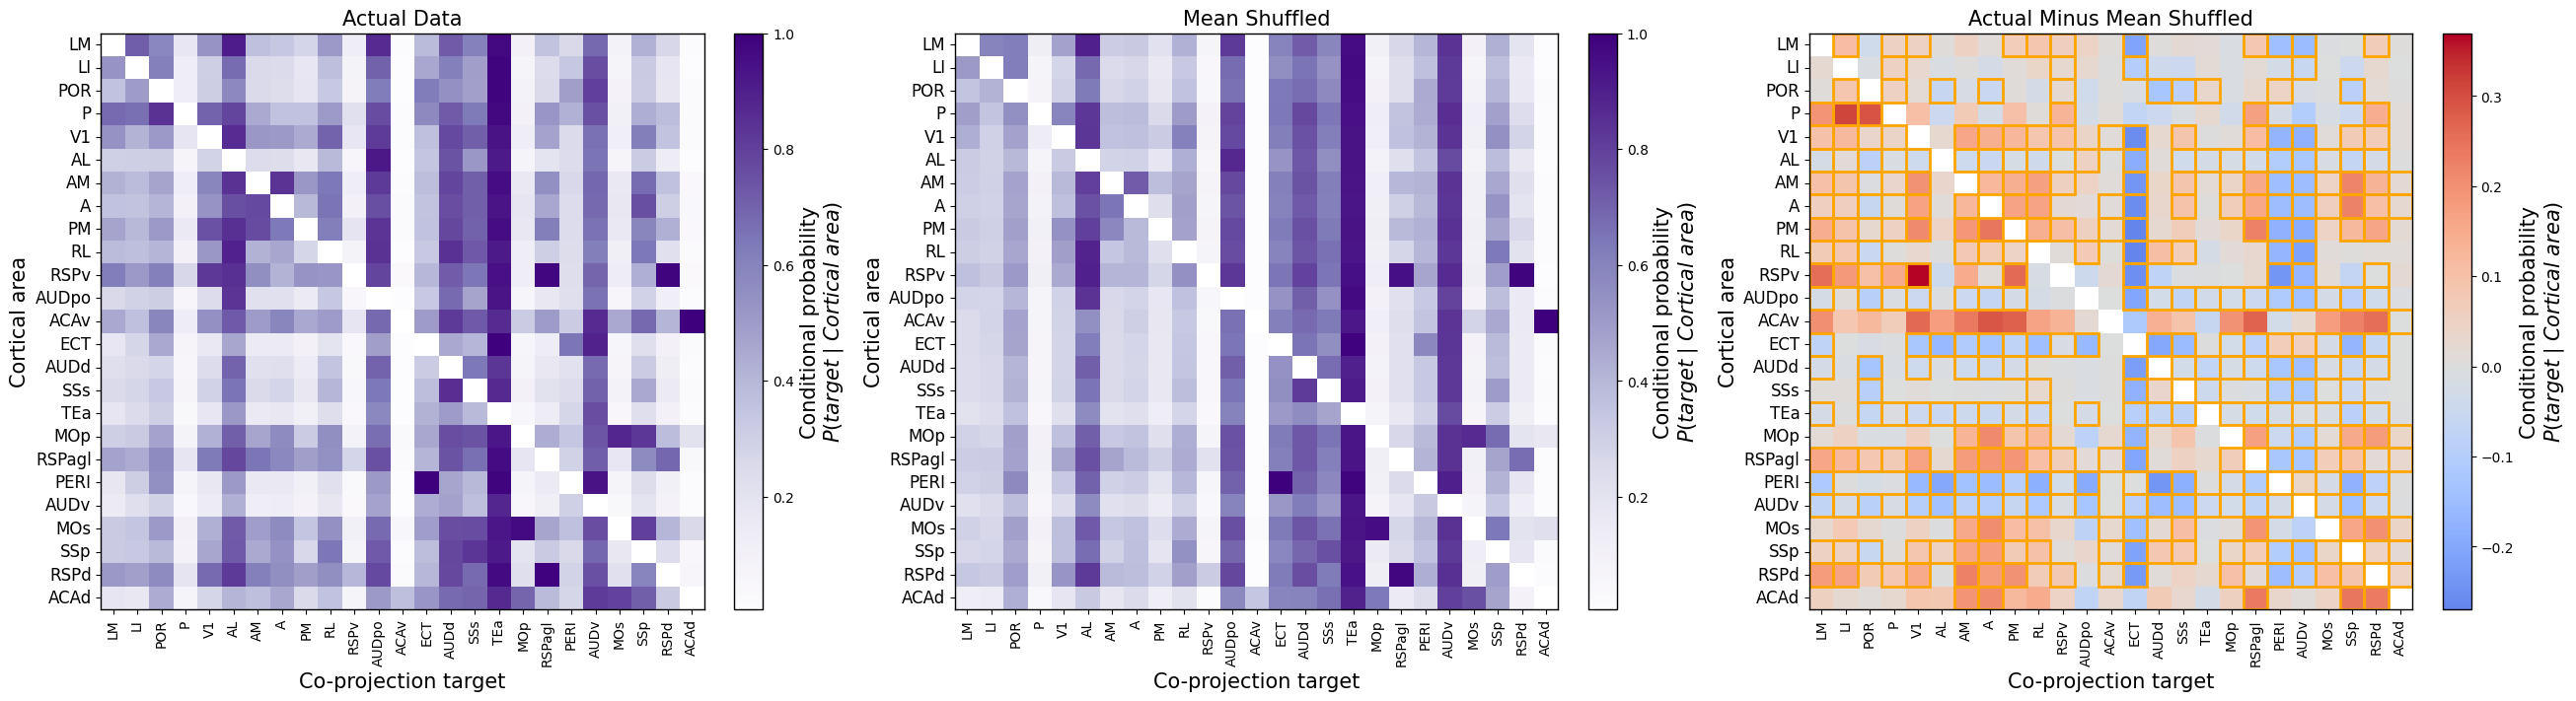

In [9]:

#analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
fig, axs = plt.subplots(1, 3, figsize=(26, 7), constrained_layout=True)

titles = ['Actual Data', 'Mean Shuffled', 'Actual Minus Mean Shuffled']
for analysis_num, analysis_type in enumerate(['cubelet']):
    if analysis_type != 'main':
        actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
    elif analysis_type == 'main':
        actual_data = conditional_probability_dict['area_is_main']
    orig_df = actual_data.copy(deep=True)
    combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
    div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
    div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    dfs = [actual_data, conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = actual_data.columns
    cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data_names_the_same = data_to_use.loc[all_cols].copy(deep=True)
        shortened_data = data_to_use.loc[all_cols]
        if number>1:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True)
        else:
            sb.heatmap(
                ax=axs[number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                #cbar_kws={'label': r'Conditional probability' '\n' r'$\mathit{P(target \mid Vc\ area)}$'}
            )
        axs[number].set_title(f'{titles[number]}', size=15)
        axs[number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
        if analysis_type != 'main':
            if number>1:
                for ii in shortened_data_names_the_same.index:
                    for j in shortened_data_names_the_same.columns:
                        if p_val_dict[f'all_columns'].loc[ii, j] <= 0.05:
                            row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
                            col_idx = shortened_data_names_the_same.columns.get_loc(j)  
                            axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='orange', lw=2))
        for _, spine in axs[number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        axs[number].set_ylabel('Cortical area', size=15)
        axs[number].set_xlabel('Co-projection target', size=15)
        cbar = axs[number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)
        cbar.set_label(r'Conditional probability' '\n' r'$\mathit{P(target \mid Cortical\ area)}$', fontsize=15)

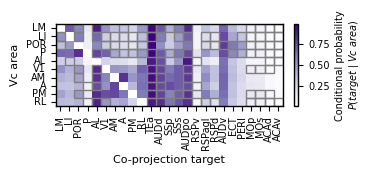

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram
plt.figure(figsize=(3.6, 1.5), constrained_layout=True)

analysis_type = 'cubelet'

if analysis_type != 'main':
    actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
elif analysis_type == 'main':
    actual_data = conditional_probability_dict['area_is_main']

cols = [ 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISal', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#all_cols = actual_data.columns
pairwise_distances = actual_data.corr() 
linkage_matrix = linkage(pairwise_distances, method='ward')
dendro = dendrogram(linkage_matrix, labels=actual_data.columns, no_plot=True)
column_order = dendro['ivl']
all_cols = column_order
cols = [col for col in cols if col in all_cols]
not_in = [col for col in all_cols if col not in cols]
combined = cols + not_in
shortened_data = actual_data.loc[cols][combined]
shortened_data_names_the_same = actual_data.loc[cols][combined].copy(deep=True)
sb.heatmap(
    data=fpf.convert_matrix_names(shortened_data), 
    cmap='Purples',
    xticklabels=True, 
    yticklabels=True, 
    cbar_kws={'label': 'conditional probability'}
)


plt.tick_params(axis='y', which='major', labelsize=7, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=7, rotation=90)
ax = plt.gca()  # Get the current axis for further adjustments
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=7)
cbar.set_label(r'Conditional probability' '\n' r'$\mathit{P(target \mid Vc\ area)}$', fontsize=7)

for ii in shortened_data_names_the_same.index:
    for j in shortened_data_names_the_same.columns:
        if p_val_dict[f'shuff_cubelet'].loc[ii, j] > 0.05:
            row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
            col_idx = shortened_data_names_the_same.columns.get_loc(j)  
            ax.add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=1))
plt.ylabel('Vc area', size=8)
plt.xlabel('Co-projection target', size=8)
plt.show()


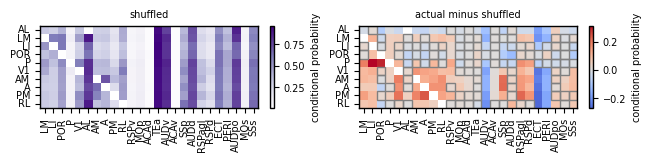

In [ ]:
# #plot shuffled 

# #analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area']
# fig, axs = plt.subplots(1, 2, figsize=(6.4, 1.5), constrained_layout=True)

# titles = ['shuffled', 'actual minus shuffled']
# for analysis_num, analysis_type in enumerate(['cubelet']):
#     if analysis_type != 'main':
#         actual_data = conditional_probability_dict[f'homogenous_across_{analysis_type}']
#     elif analysis_type == 'main':
#         actual_data = conditional_probability_dict['area_is_main']
#     orig_df = actual_data.copy(deep=True)
#     combined_dif = actual_data - conditional_probability_dict[f'shuff_{analysis_type}']
#     div_df = np.log2(actual_data / conditional_probability_dict[f'shuff_{analysis_type}'])
#     div_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     dfs = [conditional_probability_dict[f'shuff_{analysis_type}'], combined_dif]
#     cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
#     all_cols = actual_data.columns
#     cols = [col for col in cols if col in all_cols]
#     for number, title in enumerate(titles):
#         data_to_use = dfs[number].copy(deep=True)
#         shortened_data_names_the_same = data_to_use.loc[cols].copy(deep=True)
#         shortened_data = data_to_use.loc[cols]
#         if number>0:
#             sb.heatmap(
#                 ax=axs[number], 
#                 data=fpf.convert_matrix_names(shortened_data), 
#                 cmap='coolwarm', center=0,
#                 xticklabels=True, 
#                 yticklabels=True, 
#                 cbar_kws={'label': 'conditional probability'})
#         else:
#             sb.heatmap(
#                 ax=axs[number], 
#                 data=fpf.convert_matrix_names(shortened_data), 
#                 cmap='Purples',
#                 xticklabels=True, 
#                 yticklabels=True, 
#                 cbar_kws={'label': 'conditional probability'}
#             )
        
#         axs[number].set_title(f'{titles[number]}', size =7)
#         axs[number].tick_params(axis='y', which='major', labelsize=7, rotation=0)
#         axs[number].tick_params(axis='x', which='major', labelsize=7, rotation=90)
#         if analysis_type != 'main':
#             if number>0:
#                 for ii in shortened_data_names_the_same.index:
#                     for j in shortened_data_names_the_same.columns:
#                         if p_val_dict[f'shuff_cubelet'].loc[ii, j] > 0.05:
#                             row_idx = shortened_data_names_the_same.index.get_loc(ii)  # get the index of the row name
#                             col_idx = shortened_data_names_the_same.columns.get_loc(j)  
#                             axs[number].add_patch(Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='grey', lw=1))
#         for _, spine in axs[number].spines.items():
#             spine.set_visible(True)
#             spine.set_color('black')
#             spine.set_linewidth(1)
#         cbar = axs[number].collections[0].colorbar
#         cbar.outline.set_visible(True)
#         cbar.outline.set_edgecolor('black')
#         cbar.outline.set_linewidth(1)
#         cbar.ax.tick_params(labelsize=7)
#         cbar.set_label('conditional probability', fontsize=7)

In [6]:
#plot mean cosine similarity of conditional probabilities
#let's first calculate the mean conditional probability across mice
key='homogenous_across_cubelet'
which = 'cubelet'
shuff = f'shuff_{which}'
common_cols = all_combined[key].columns

cols = [ 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISal', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cond_prob_dict = {}
shuff_cond_prob_dict = {}
mouse_cond_prob_minus_shuff = {}
for mouse in mice:
    cond_prob_dict[mouse]= fpf.get_cond_prob(matrix = combined_dict[mouse][key], columns = cols_reordered, index = cols_reordered)
    shuff_cond_prob_dict[mouse] = fpf.get_cond_prob(matrix = combined_dict[mouse][shuff], columns = cols_reordered, index = cols_reordered)
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob_{mouse}_collated.pkl')
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for column_name in shuffled_cond_prob.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_cond_prob[column_name].mean()
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
    #shuff_cond_prob_dict[mouse] = mean_val_matrix
    mouse_cond_prob_minus_shuff[mouse] = cond_prob_dict[mouse]-mean_val_matrix



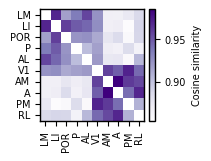

In [7]:
plt.figure(figsize=(2, 1.5), constrained_layout=True)

dict_to_look = cond_prob_dict  # Only use the first dictionary
title = 'Actual'

cosine_dict = {}
for mouse in mice:
    cosine_dict[mouse] = fpf.get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols=cols)

# Calculate cosine similarity to itself
# to_itself_cosine = {}
# for area in cols:
#     area_list = []
#     for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
#         neurons_1 = dict_to_look[mouse_a].loc[area].drop([area])
#         neurons_2 = dict_to_look[mouse_b].loc[area].drop([area])
#         bl = np.array(neurons_1).reshape(1, -1)
#         bl_2 = np.array(neurons_2).reshape(1, -1)
#         area_list.append(cosine_similarity(bl, bl_2))
#     to_itself_cosine[area] = np.mean(area_list)

cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
cosine_df = cosine_df.loc[cols][cols]
# for col in cols:
#     cosine_df.loc[col, col] = to_itself_cosine[col]

sb.heatmap(
    data=fpf.convert_matrix_names(cosine_df),
    cmap='Purples', #'RdBu_r',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Cosine similarity'}
)


plt.tick_params(axis='y', which='major', labelsize=7, rotation=0)
plt.tick_params(axis='x', which='major', labelsize=7, rotation=90)
ax = plt.gca()  # Get the current axis for further adjustments
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

cbar = ax.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('Cosine similarity', fontsize=7)

plt.show()


In [6]:
shuffled_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled__neuron_numbers_cubelet__collated.pkl')
shuffled_2_combinations = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_cubelet_2_comb__collated.pkl')
shuffle_total_numbers = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/total_neuron_numbers_cubelet__collated.pkl')
    

In [34]:
dorsal_stream = ['VISa', 'VISam', 'VISpm', 'VISrl']
ventral_stream = ['VISpor', 'VISpl', 'VISl', 'VISli', 'VISal']
from scipy.stats import norm

barcodes = all_combined['homogenous_across_cubelet']
total_combinations = len(list(itertools.combinations(cols_reordered, 2)))
all_cols = barcodes.columns
cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in all_cols]
probs_df = pd.DataFrame(index=['probs_actual', 'probs_joint', 'log_OR_actual', 'mean_shuf', 'p_value'])  
for column_name in shuffled_2_combinations.columns:
    if any(substring in column_name for substring in cols):
        col, col_2= map(str.strip, column_name.split(','))
# for col in cols_reordered:
#     for col_2 in cols_reordered:
#         if col != col_2:
        if col in all_cols and col_2 in all_cols:
            prob_df = pd.DataFrame()
            prob_df["a"] = barcodes[col].astype(bool)
            prob_df["b"] = barcodes[col_2].astype(bool)
            prob_df["matching"] = prob_df.apply(lambda x: 1 if x['a'] and x['b'] else 0, axis=1)
            probs_actual = prob_df["matching"].sum() / len(barcodes)
            probs_joint = (prob_df["a"].sum() / len(barcodes)) * (prob_df["b"].sum() / len(barcodes))
            probs_df.loc['probs_actual', f'{col}, {col_2}'] = probs_actual
            probs_df.loc['probs_joint', f'{col}, {col_2}'] = probs_joint
            if f'{col}, {col_2}' in shuffled_2_combinations.columns:
                column_name = f'{col}, {col_2}'
            elif f'{col_2}, {col}' in shuffled_2_combinations.columns:
                column_name = f'{col_2}, {col}'
            shuff_actual_prob = shuffled_2_combinations[column_name]/shuffle_total_numbers[0]
            shuff_joint_prob = (shuffled_numbers[col]/shuffle_total_numbers[0]) * (shuffled_numbers[col_2]/shuffle_total_numbers[0])
            # shuff_odds_actual = shuff_actual_prob/ (1-shuff_actual_prob)
            # shuff_odds_joint = shuff_joint_prob/ (1-shuff_joint_prob)
            shuff_effect = (shuff_actual_prob/shuff_joint_prob).astype(float)
            shuff_log_effect = np.log2(shuff_effect+1e-3)
            mean_shuff_log_effect = shuff_log_effect.mean()
            # actual_odds = (probs_actual) / (1 - (probs_actual))
            # joint_odds = (probs_joint) / (1 - (probs_joint))
            actual_effect = probs_actual/probs_joint
            # probs_df.loc['odds_actual', f'{col}, {col_2}'] = probs_actual
            # probs_df.loc['odds_joint', f'{col}, {col_2}'] = joint_odds
            probs_df.loc['mean_shuf', f'{col}, {col_2}'] = mean_shuff_log_effect
            #probs_df.loc['mean_shuf_subtracted', f'{col}, {col_2}'] = np.log2(actual_effect - shuff_effect.mean())
            probs_df.loc['log_OR_actual', f'{col}, {col_2}'] = np.log2(actual_effect +1e-3)
            mu, std = norm.fit(shuff_effect)
            if actual_effect >= shuff_effect.mean():
                p_val = norm.sf(actual_effect, loc=mu, scale=std) * 2  # two-sided
            else:
                p_val = norm.cdf(actual_effect, loc=mu, scale=std) * 2
            # if OR_actual >= oddd.mean():
            #     p_val = ((sum(1 for value in oddd if value > OR_actual)+1)/(len(oddd)+1))*2
            # elif val_to_comp < mean_corr:
            #     p_val = ((sum(1 for value in oddd if value < OR_actual)+1)/(len(oddd)+1))*2 
            p_val_adj = p_val* total_combinations
            probs_df.loc['p_value', f'{col}, {col_2}'] = p_val_adj
to_plot = probs_df.T
to_plot['-log10_p_value'] = -np.log10(to_plot['p_value'])
to_plot['shuf-sub'] = to_plot['log_OR_actual'] -to_plot['mean_shuf']


In [18]:
def classify_stream(pair):
    regions = pair.split(', ')
    is_dorsal = [region in dorsal_stream for region in regions]
    is_ventral = [region in ventral_stream for region in regions]
    
    if all(is_dorsal):
        return 'dorsal'
    elif all(is_ventral):
        return 'ventral'
    elif any(is_dorsal) and any(is_ventral):
        return 'dorsal-ventral'
    else:
        return 'other'

dot_size = 10
alpha_val = 0.5

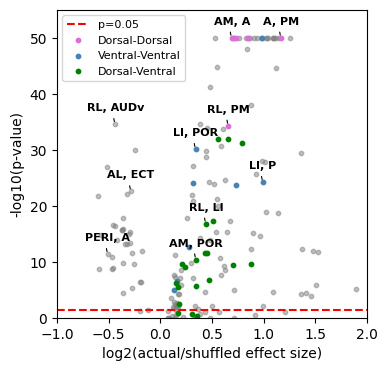

In [41]:
alpha_val_stream = 1
to_plot['-log10_p_value'] = to_plot['-log10_p_value'].clip(upper=50)
to_plot['stream'] = to_plot.index.map(classify_stream)
plt.figure(figsize=(4, 4))
plt.scatter(
    to_plot[to_plot['stream'] == 'other']['shuf-sub'],
    to_plot[to_plot['stream'] == 'other']['-log10_p_value'],
    color='grey', s=dot_size, alpha=alpha_val)

plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal']['-log10_p_value'],
    color='orchid', alpha=alpha_val_stream, s=dot_size, label='Dorsal-Dorsal'
)

plt.scatter(
    to_plot[to_plot['stream'] == 'ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'ventral']['-log10_p_value'],
    color='steelblue', alpha=alpha_val_stream, s=dot_size, label='Ventral-Ventral'
)


plt.scatter(
    to_plot[to_plot['stream'] == 'dorsal-ventral']['shuf-sub'],
    to_plot[to_plot['stream'] == 'dorsal-ventral']['-log10_p_value'],
    color='green', alpha=alpha_val_stream, s=dot_size, label='Dorsal-Ventral'
)


plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')  # Horizontal line at p=0.05
convert_dict = {
    "VISl": "LM",
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISam": "AM"
}

areas_to_check = ['VISrl, AUDv', 'VISal, ECT', 'PERI, VISa', 'VISam, VISa', 'VISli, VISpl', 'VISam, VISpor', 'VISa, VISpm', 'VISli, VISpor', 'VISrl, VISli', 'VISrl, VISpm']

for pair in areas_to_check:
    areas = pair.split(', ') 
    x_val = to_plot.loc[pair, 'shuf-sub']
    y_val = to_plot.loc[pair, '-log10_p_value']
    offset_y = y_val + 2
    if areas[0] in convert_dict:
        areas[0] = convert_dict[areas[0]]
    if areas[1] in convert_dict:
        areas[1] = convert_dict[areas[1]]
    plt.annotate(
                f'{areas[0]}, {areas[1]}', 
                xy=(x_val, y_val), 
                xytext=(x_val, offset_y),  
                fontsize=8, ha='center', va='bottom', color='black', fontweight='bold',
                arrowprops=dict(
                    arrowstyle="-", color="black", linewidth=0.8, alpha=1, 
                    connectionstyle="arc3,rad=0.2"
                )  
            )


plt.xlabel('log2(actual/shuffled effect size)')
plt.ylabel('-log10(p-value)')

plt.ylim(0, 55)
plt.xlim(-1, 2)
plt.legend(loc='upper left', prop={'size': 8})
plt.show()


Now plot differences in frequency of targeting against AP soma position

In [3]:
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']

mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_mice_dict = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #normalise barcodes to total sum
    barcodes = barcodes[barcodes.astype(bool).sum(axis=1)>0]

    new_dict['homog_across_cubelet'] =fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    
    #which_mice = which_mice[combine_all_mice[HVA_cols].astype(bool).sum(axis=1)>0]
    #combine_all_mice = combine_all_mice[combine_all_mice[HVA_cols].astype(bool).sum(axis=1)>0]
    #new_dict['homog_across_cubelet'] = assigned_areas[assigned_areas.astype(bool).sum(axis=1)>2]
    #new_dict['homog_across_cubelet'] = assigned_areas[assigned_areas[HVA_cols].astype(bool).sum(axis=1)>0]
    # new_dict['homog_across_cubelet_shuffled'] =fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=True, dummy_data = False)
    # new_dict['homog_across_area'] =fpf.homog_across_area(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False)
    # new_dict['homog_across_area_shuffled'] =fpf.homog_across_area(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=True)

    combined_mice_dict[mouse] = new_dict

In [4]:
#not ness since no barcodes are shared between mice, but in case of re-use
def add_prefix_to_index(df, prefix):
    df = df.copy()  # Avoid modifying the original DataFrame
    df.index = [f"{prefix}_{idx}" for idx in df.index]
    return df
index_adj_combined_dict = {}

for mouse in mice:
    index_adj_combined_dict[mouse] = add_prefix_to_index(combined_mice_dict[mouse]['homog_across_cubelet'], mouse)



In [5]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
key = 'homog_across_cubelet'
common_columns = set(combined_mice_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_mice_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_mice_dict['FIAA55.4d'][key].columns)
)
#let's make sure that all the areas are cortical (areas such as HPF are unintentially side bits of cubelets and never main target, and more likely registration errors)
common_cols_cortex = []
for col in common_columns:
    if col == 'Contra':
        common_cols_cortex.append(col)
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
combine_all_mice = pd.concat([index_adj_combined_dict['FIAA45.6a'][common_cols_cortex], index_adj_combined_dict['FIAA45.6d'][common_cols_cortex], index_adj_combined_dict['FIAA55.4d'][common_cols_cortex]])
which_mice = pd.DataFrame(columns = ['mice'], index= combine_all_mice.index)
which_mice.loc[index_adj_combined_dict['FIAA45.6a'].index] = 'FIAA45.6a'
which_mice.loc[index_adj_combined_dict['FIAA45.6d'].index] = 'FIAA45.6d'
which_mice.loc[index_adj_combined_dict['FIAA55.4d'].index] = 'FIAA55.4d'


In [6]:
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False)
AUDp_id =bg_atlas.structures['AUDp']['id']
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
AUDp_mask = rsp.make_structure_mask([AUDp_id], direct_only=False)
indices_AUDp = np.argwhere(AUDp_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_AUDp[:, 0])
min_y = np.min(indices_AUDp[:, 0])
AP_midpoint_A1 = ((max_y - min_y) /2) + min_y
posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = AUDp_mask.shape[2] // 2
contra_mask = np.zeros_like(AUDp_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1


#now lets load the barcodes
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mouse_dict_AP_source = {}
mouse_barcodes_by_source = {}
for mouse in mice:
    #if mouse == 'FIAA45.6d':
    AP_position_dict = {}
    barcodes = pd.read_pickle(f"{proj_path}/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl")
    #indices = which_mice[which_mice['mice'] == mouse].index
    #barcodes = barcodes.loc[indices]
    lcm_directory = proj_path/f"{mouse}/LCM"
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    AP_samples = {}
    AP_source_filtered = {}
    all_AUDp_samples = np.unique(ROI_3D *  AUDp_mask * contra_mask)
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample != 0]
    all_AUDp_samples = [sample for sample in all_AUDp_samples if sample in barcodes.columns]
    for sample in all_AUDp_samples:
        centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
        AP_position_dict[sample] = centroid[0]-min_y#AP_midpoint_A1
    mouse_dict_AP_source[mouse]=AP_position_dict

In [7]:
#get list of sources from each barcode, then create a dictionary
#soma = pd.DataFrame(barcodes.idxmax(axis=1))
def get_AP_position(row, dictionary):
    key = row[0]
    if key in dictionary.keys():
        return dictionary[key]
    else:
        return None  # or any other default value you want to use if the key is not found

barcodes_dict = {}
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
AP_position_dict_list = {}
for mouse in mice:
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    barcodes= add_prefix_to_index(barcodes, mouse)
    #barcodes_assigned_area =fpf.area_is_main(parameters_path= parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    #barcodes_assigned_area = barcodes_assigned_area[barcodes_assigned_area.astype(bool).sum(axis=1)>2]#increased as now AUDp is here
    
    #barcodes = barcodes.loc[barcodes_assigned_area.index.to_list()]
    soma = pd.DataFrame(barcodes.idxmax(axis=1))
    soma['AP_position'] = soma.apply(lambda row: get_AP_position(row, mouse_dict_AP_source[mouse]), axis=1)
    #barcodes_dict[mouse] = barcodes_assigned_area.drop(columns=['AUDp'])
    #soma_filtered = soma.loc[combined_mice_dict[mouse]['homog_across_cubelet'].index]
    AP_position_dict_list[mouse] = soma#soma_filtered
AP_position_dict_list_combined= pd.concat([AP_position_dict_list['FIAA45.6a'], AP_position_dict_list['FIAA45.6d'], AP_position_dict_list['FIAA55.4d']])

In [45]:
area_AP_dict = {}
cols = ['VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISal', 'VISam', 'VISa', 'VISpm', 'VISrl']
for col in cols:
    vals = []
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        mouse_bcs = combine_all_mice.loc[mouse_ind]
        proj_area = mouse_bcs[mouse_bcs[col]>0]
        indices = proj_area.index
        if len(proj_area)>0:
            AP_positions = AP_position_dict_list_combined.loc[indices]['AP_position']
            vals.append(np.mean(AP_positions))
    
    area_AP_dict[col] = vals

In [52]:
area_AP_dict['VISrl']

[25.642623235302505, 24.484261244933055, 25.645064041588824]

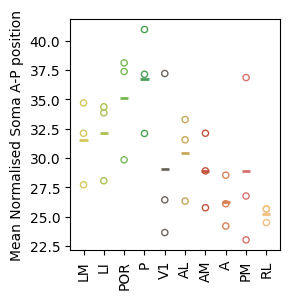

In [57]:
HVA_colors_updated = {
    'VISp': '#6E665E',
    'VISpor': '#79B855',
    'VISli': '#AAC255',
    'VISpl': '#4C9E57',
    'VISl': '#D6C759',
    'VISal': '#C7A859',
    'VISrl': '#F0BE7E',
    'VISa': '#D78257',
    'VISam': '#C2543C',
    'VISpm': '#D7716C'
}
convert_dict = {
    "VISl": "LM",
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISam": "AM"
}

fig, ax = plt.subplots(figsize=(3, 3))

keys = list(area_AP_dict.keys())

for i, key in enumerate(keys):
    values = area_AP_dict[key]
    # Pull color from the dictionary; default to black if key not found
    color = HVA_colors_updated.get(key, "black")
    
    # 1) Plot individual points as a scatter
    xvals = np.full(len(values), i)  # same x position for the group's points
    ax.scatter(xvals, values,marker='o',
    facecolors='none',    
    edgecolors=color, s=20, label=key, color=color)
    
    # 2) Draw a horizontal line at the mean in the same color
    mean_val = np.mean(values)
    ax.hlines(y=mean_val, xmin=i - 0.2, xmax=i + 0.2, 
              colors=color, linewidth=2)

converted_labels = [convert_dict.get(k, k) for k in keys]
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(converted_labels, rotation=90)

ax.set_ylabel("Mean Normalised Soma A-P position")


plt.tight_layout()
plt.show()

In [58]:
import pandas as pd
import statsmodels.formula.api as smf


area_dic= {}
for area in combine_all_mice.columns:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'proj_freq'])
    ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        mouse_ind = which_mice[which_mice['mice']==mouse].index
        ap_corr_mouse = AP_position_dict_list_combined.loc[mouse_ind]['AP_position']
        mouse_bcs = combine_all_mice.loc[mouse_ind].astype(bool).astype(int)
        for AP in ap_corr_mouse.unique():
            indices = ap_corr_mouse[ap_corr_mouse==AP]
            if len(indices)<5:
                continue
            else:
                freq = mouse_bcs.loc[indices.index][area].mean()
                new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP], "proj_freq": [freq]})
                area_df = pd.concat([area_df, new_row], ignore_index=True)
        area_dic[area] = area_df




In [59]:
visual_areas = ['VISa', 'VISal', 'VISam', 'VISpm', 'VISp', 'VISpor', 'VISrl', 'VISl', 'VISli', 'VISpl']
area_p_values = pd.DataFrame(columns=['p_value', 'p_val_adj'])
area_results = {}
for area in visual_areas:
    df_long = area_dic[area]
    model = smf.mixedlm(
        formula="proj_freq ~ AP_position",
        data=df_long,
        groups=df_long["mouse"],  # random intercept only
        re_formula="1"            # or omit if you want the default random intercept
    )

    res = model.fit()
    area_results[area]=res

    # Extract the p-value for the slope of AP_position
    p_value_ap = res.pvalues["AP_position"]
    area_p_values.loc[area, 'p_value'] = p_value_ap
    area_p_values.loc[area, 'p_val_adj'] = p_value_ap*len(visual_areas)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/camp/home/turnerb/.cond

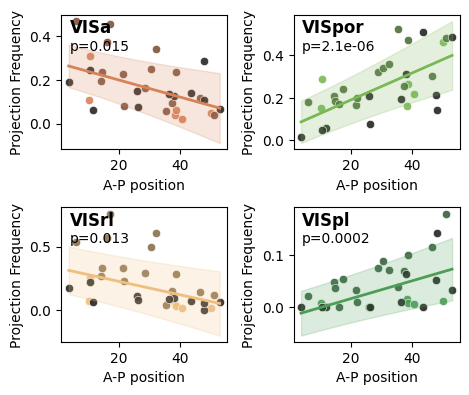

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors

HVA_colors_updated = {
    'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
    'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
    'VISam': '#C2543C', 'VISpm': '#D7716C'
}

areas = ['VISa', 'VISpor', 'VISrl', 'VISpl']
fig, axes = plt.subplots(2, 2, figsize=(5, 4), sharex=False, sharey=False)

for i, area in enumerate(areas):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    df_long = area_dic[area]

    main_color = HVA_colors_updated.get(area, 'black')

    ap_range = np.linspace(df_long["AP_position"].min(), df_long["AP_position"].max(), 50)
    
    pred_df = pd.DataFrame({
        "mouse": ["AverageMouse"] * len(ap_range),
        "AP_position": ap_range
    })
    
    pred_df["proj_freq_pred"] = area_results[area].predict(pred_df)

    ap_position_se = area_results[area].bse["AP_position"]
    intercept_se = area_results[area].bse["Intercept"]

    ci_margin = 1.96 * np.sqrt(intercept_se**2 + (ap_range * ap_position_se)**2)
    pred_df["lower_CI"] = pred_df["proj_freq_pred"] - ci_margin
    pred_df["upper_CI"] = pred_df["proj_freq_pred"] + ci_margin

    mouse_ids = df_long["mouse"].unique()
    color_palette = sb.dark_palette(main_color, len(mouse_ids), reverse=True)

    for j, mouse in enumerate(mouse_ids):
        sb.scatterplot(
            data=df_long[df_long["mouse"] == mouse], 
            x="AP_position", y="proj_freq", 
            color=color_palette[j], 
            alpha=0.9, ax=ax
        )
    
    ax.plot(
        pred_df["AP_position"], 
        pred_df["proj_freq_pred"], 
        color=main_color, 
        linewidth=2,
        label="Mixed Model Fit"
    )
    
    ax.fill_between(
        pred_df["AP_position"], 
        pred_df["lower_CI"], 
        pred_df["upper_CI"], 
        color=main_color, alpha=0.2, label="95% CI"
    )

    ax.set_title("")
    
    p_value_corrected = f"p={area_p_values.loc[area]['p_val_adj']:.2g}"
    ax.text(
        0.05, 0.82,  
        p_value_corrected, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10, color='black'
    )

    ax.text(
        0.05, 0.97,  
        area, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=12, fontweight='bold', color='black'
    )

    ax.set_xlabel("A-P position")
    ax.set_ylabel("Projection Frequency")

plt.tight_layout()
plt.show()


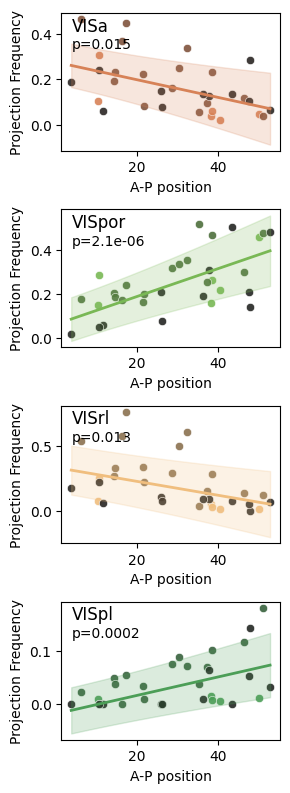

In [64]:
HVA_colors_updated = {
    'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
    'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
    'VISam': '#C2543C', 'VISpm': '#D7716C'
}

areas = ['VISa', 'VISpor', 'VISrl', 'VISpl']

# 4 rows and 1 column => 4 subplots in a single vertical column
fig, axes = plt.subplots(4, 1, figsize=(3, 8), sharex=False, sharey=False)

for i, area in enumerate(areas):
    ax = axes[i]  # Each subplot is just axes[i], no row/col needed
    df_long = area_dic[area]

    main_color = HVA_colors_updated.get(area, 'black')

    ap_range = np.linspace(df_long["AP_position"].min(),
                           df_long["AP_position"].max(),
                           50)
    
    pred_df = pd.DataFrame({
        "mouse": ["AverageMouse"] * len(ap_range),
        "AP_position": ap_range
    })
    
    pred_df["proj_freq_pred"] = area_results[area].predict(pred_df)

    ap_position_se = area_results[area].bse["AP_position"]
    intercept_se = area_results[area].bse["Intercept"]

    ci_margin = 1.96 * np.sqrt(intercept_se**2 + (ap_range * ap_position_se)**2)
    pred_df["lower_CI"] = pred_df["proj_freq_pred"] - ci_margin
    pred_df["upper_CI"] = pred_df["proj_freq_pred"] + ci_margin

    mouse_ids = df_long["mouse"].unique()
    color_palette = sb.dark_palette(main_color, len(mouse_ids), reverse=True)

    # Plot each mouse's points
    for j, mouse in enumerate(mouse_ids):
        sb.scatterplot(
            data=df_long[df_long["mouse"] == mouse], 
            x="AP_position", y="proj_freq", 
            color=color_palette[j], 
            alpha=0.9, ax=ax
        )
    
    # Plot the predicted line
    ax.plot(
        pred_df["AP_position"], 
        pred_df["proj_freq_pred"], 
        color=main_color, 
        linewidth=2,
        label="Mixed Model Fit"
    )
    
    # Fill between lower_CI and upper_CI
    ax.fill_between(
        pred_df["AP_position"], 
        pred_df["lower_CI"], 
        pred_df["upper_CI"], 
        color=main_color, alpha=0.2, label="95% CI"
    )

    ax.set_title("")
    
    p_value_corrected = f"p={area_p_values.loc[area]['p_val_adj']:.2g}"
    ax.text(
        0.05, 0.82,  
        p_value_corrected, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10, color='black'
    )

    ax.text(
        0.05, 0.97,  
        area, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=12, color='black'
    )

    ax.set_xlabel("A-P position")
    ax.set_ylabel("Projection Frequency")

plt.tight_layout()
plt.show()

Now for fig S4, lets compare conditional probability given targeting AP position in vis cortex

In [42]:
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex
indices_VIS = np.argwhere(VIS_mask == 1)

#select anterior and posterior parts of A1
max_y = np.max(indices_VIS[:, 0])
min_y = np.min(indices_VIS[:, 0])
AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1

In [73]:
#take AP position of cubelets containing visual cortex (and also specifically V1)
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
AP_position_dict = {}
AP_cond_prob_dict = {}
for mouse in mice:
    new_dict = {}
    cond_prob_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #sample_vol_and_regions =pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=pathlib.Path(parameters['lcm_directory']),
        area_threshold=0.5) #must contain at least 50% visual cortex
    V1_containing = areas_only_grouped[areas_only_grouped['VISp']>0].index.to_list()
    lcm_directory = pathlib.Path(parameters['lcm_directory'])
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    for sample in V1_containing:
        if sample in barcodes.columns:
            centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
            filtered_bc = barcodes[barcodes[sample]>0]
            if len(filtered_bc)<5:
                continue
            new_dict[sample] = centroid[0]-min_y
            filtered_bc.drop(columns=[sample], inplace=True)
            filtered_with_area = fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = filtered_bc, cortical=True, shuffled=False, IT_only=True)
            cond_prob_dict[sample] = filtered_with_area.astype(bool).mean(axis=0)
    AP_position_dict[mouse] = new_dict
    AP_cond_prob_dict[mouse] = cond_prob_dict
#for each mouse, given that a cubelet is in a particular AP position, what are the probablity of targeting other areas?

In [52]:
visual_areas = ['VISa', 'VISal', 'VISam', 'VISpm', 'VISp', 'VISpor', 'VISrl', 'VISl', 'VISli', 'VISpl']

In [81]:
area_dic= {}
for area in visual_areas:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'conditional_prob'])
    # ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        for sample in AP_position_dict[mouse].keys():
            AP_pos = AP_position_dict[mouse][sample]
            cond_prob = AP_cond_prob_dict[mouse][sample][area]
            new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP_pos], "conditional_prob": [cond_prob]})
            area_df = pd.concat([area_df, new_row], ignore_index=True)
    area_dic[area] = area_df

In [84]:
import statsmodels.formula.api as smf
area_p_values = pd.DataFrame(columns=['p_value', 'p_val_adj'])
area_results = {}
for area in visual_areas:
    df_long = area_dic[area]
    model = smf.mixedlm(
        formula="conditional_prob ~ AP_position",
        data=df_long,
        groups=df_long["mouse"],  # random intercept only
        re_formula="1"            # or omit if you want the default random intercept
    )

    res = model.fit()
    area_results[area]=res

    # Extract the p-value for the slope of AP_position
    p_value_ap = res.pvalues["AP_position"]
    area_p_values.loc[area, 'p_value'] = p_value_ap
    area_p_values.loc[area, 'p_val_adj'] = p_value_ap*len(visual_areas)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


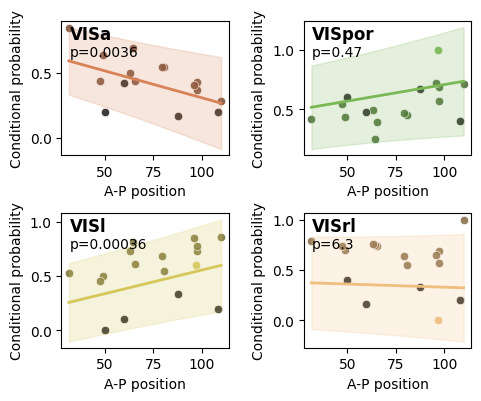

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
convert_dict = {
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISrl": "RL",
    "VISam": "AM",
    "VISl": "LM"
}
HVA_colors_updated = {
    'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
    'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
    'VISam': '#C2543C', 'VISpm': '#D7716C'
}

areas = ['VISa', 'VISpor', 'VISl', 'VISrl']
HVA_only = [s for s in visual_areas if s != 'VISp']
fig, axes = plt.subplots(3, 3, figsize=(7, 5), sharex=False, sharey=False)

for i, area in enumerate(HVA_only):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    df_long = area_dic[area]

    main_color = HVA_colors_updated.get(area, 'black')

    ap_range = np.linspace(df_long["AP_position"].min(), df_long["AP_position"].max(), 50)
    
    pred_df = pd.DataFrame({
        "mouse": ["AverageMouse"] * len(ap_range),
        "AP_position": ap_range
    })
    
    pred_df["conditional_prob_pred"] = area_results[area].predict(pred_df)

    ap_position_se = area_results[area].bse["AP_position"]
    intercept_se = area_results[area].bse["Intercept"]

    ci_margin = 1.96 * np.sqrt(intercept_se**2 + (ap_range * ap_position_se)**2)
    pred_df["lower_CI"] = pred_df["conditional_prob_pred"] - ci_margin
    pred_df["upper_CI"] = pred_df["conditional_prob_pred"] + ci_margin

    mouse_ids = df_long["mouse"].unique()
    color_palette = sb.dark_palette(main_color, len(mouse_ids), reverse=True)

    for j, mouse in enumerate(mouse_ids):
        sb.scatterplot(
            data=df_long[df_long["mouse"] == mouse], 
            x="AP_position", y="conditional_prob", 
            color=color_palette[j], 
            alpha=0.9, ax=ax
        )
    
    ax.plot(
        pred_df["AP_position"], 
        pred_df["conditional_prob_pred"], 
        color=main_color, 
        linewidth=2,
        label="Mixed Model Fit"
    )
    
    ax.fill_between(
        pred_df["AP_position"], 
        pred_df["lower_CI"], 
        pred_df["upper_CI"], 
        color=main_color, alpha=0.2, label="95% CI"
    )

    ax.set_title("")
    
    p_value_corrected = f"p={area_p_values.loc[area]['p_val_adj']:.2g}"
    ax.text(
        0.05, 0.82,  
        p_value_corrected, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10, color='black'
    )

    ax.text(
        0.05, 0.97,  
        convert_dict[area], 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=12, fontweight='bold', color='black'
    )

    ax.set_xlabel("A-P position")
    ax.set_ylabel(f"P({convert_dict[area]}|V1 A-P)")

plt.tight_layout()
plt.show()


How about madial lateral positioning?

In [ ]:
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
VIS_mask = rsp.make_structure_mask([669], direct_only=False) #669 is id for whole visual cortex


#select anterior and posterior parts of A1
x_midpoint = VIS_mask.shape[2] // 2
contra_mask = np.zeros_like(VIS_mask, dtype=bool)
contra_mask[:, :, x_midpoint:] = 1
VIS_mask_ipsi = VIS_mask*contra_mask
indices_VIS = np.argwhere(VIS_mask_ipsi == 1)
max_x = np.max(indices_VIS[:, 2])
min_x = np.min(indices_VIS[:, 2])
ML_midpoint_VIS = ((max_x - min_x) / 2) + min_x

# AP_midpoint_VIS = ((max_y - min_y) /2) + min_y
# posterior_neurons = indices_AUDp[indices_AUDp[:, 0]>=AP_midpoint_A1]
# anterior_neurons = indices_AUDp[indices_AUDp[:, 0]<AP_midpoint_A1]
#now select only the ipsiliateral side of where was injected
# x_midpoint = VIS_mask.shape[2] // 2
# contra_mask = np.zeros_like(VIS_mask, dtype=bool)
# contra_mask[:, :, x_midpoint:] = 1
#take AP position of cubelets containing visual cortex (and also specifically V1)
proj_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq")
HVA_cols = ['VISp', 'VISpor', 'VISli', 'VISal', 'VISl', 'VISpl', 'VISpm', 'VISrl', 'VISam', 'VISa']
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
ML_position_dict = {}
ML_cond_prob_dict = {}
for mouse in mice:
    new_dict = {}
    cond_prob_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = fpf.load_parameters(directory=parameters_path)
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    #sample_vol_and_regions =pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes.columns,
        lcm_directory=pathlib.Path(parameters['lcm_directory']),
        area_threshold=0.5) #must contain at least 30% visual cortex
    V1_containing = areas_only_grouped[areas_only_grouped['VISp']>0].index.to_list()
    lcm_directory = pathlib.Path(parameters['lcm_directory'])
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    for sample in V1_containing:
        if sample in barcodes.columns:
            centroid = np.argwhere(ROI_3D == sample).mean(axis=0)
            filtered_bc = barcodes[barcodes[sample]>0]
            if len(filtered_bc)<5:
                continue
            new_dict[sample] = centroid[2]-min_x
            filtered_bc.drop(columns=[sample], inplace=True)
            filtered_with_area = fpf.homog_across_cubelet(parameters_path= parameters_path, barcode_matrix = filtered_bc, cortical=True, shuffled=False, IT_only=True)
            cond_prob_dict[sample] = filtered_with_area.astype(bool).mean(axis=0)
    ML_position_dict[mouse] = new_dict
    ML_cond_prob_dict[mouse] = cond_prob_dict
#for each mouse, given that a cubelet is in a particular AP position, what are the probablity of targeting other areas?

In [75]:
import statsmodels.formula.api as smf
area_dic= {}
for area in visual_areas:
    area_df =pd.DataFrame(columns=['mouse', 'AP_position', 'conditional_prob'])
    # ap_positions = AP_position_dict_list_combined.loc[combine_all_mice.index]['AP_position']
    #area_correlations.loc['corr_all_mice', area] = combine_all_mice[area].astype(bool).astype(int).corr(ap_positions, method='spearman')
    for mouse in mice:
        for sample in ML_position_dict[mouse].keys():
            AP_pos = ML_position_dict[mouse][sample]
            cond_prob = ML_cond_prob_dict[mouse][sample][area]
            new_row = pd.DataFrame({"mouse": [mouse], "AP_position": [AP_pos], "conditional_prob": [cond_prob]})
            area_df = pd.concat([area_df, new_row], ignore_index=True)
    area_dic[area] = area_df
area_p_values = pd.DataFrame(columns=['p_value', 'p_val_adj'])
area_results = {}
for area in visual_areas:
    df_long = area_dic[area]
    model = smf.mixedlm(
        formula="conditional_prob ~ AP_position",
        data=df_long,
        groups=df_long["mouse"],  # random intercept only
        re_formula="1"            # or omit if you want the default random intercept
    )

    res = model.fit()
    area_results[area]=res

    # Extract the p-value for the slope of AP_position
    p_value_ap = res.pvalues["AP_position"]
    area_p_values.loc[area, 'p_value'] = p_value_ap
    area_p_values.loc[area, 'p_val_adj'] = p_value_ap*len(visual_areas)

dict_keys([4, 16, 50, 78])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
convert_dict = {
    "VISl": "LM",
    "VISrl": "RL",
    "VISal": "AL",
    "VISa": "A",
    "VISp": "V1",
    "VISpor": "POR",
    "VISli": "LI",
    "VISpl": "P",
    "VISpm": "PM",
    "VISam": "AM"
}
HVA_colors_updated = {
    'VISp': '#6E665E', 'VISpor': '#79B855', 'VISli': '#AAC255', 'VISpl': '#4C9E57', 
    'VISl': '#D6C759', 'VISal': '#C7A859', 'VISrl': '#F0BE7E', 'VISa': '#D78257', 
    'VISam': '#C2543C', 'VISpm': '#D7716C'
}

areas = ['VISa', 'VISpor', 'VISl', 'VISrl']
HVA_only = [s for s in visual_areas if s != 'VISp']
fig, axes = plt.subplots(3, 3, figsize=(7, 5), sharex=False, sharey=False)

for i, area in enumerate(HVA_only):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    df_long = area_dic[area]

    main_color = HVA_colors_updated.get(area, 'black')

    ap_range = np.linspace(df_long["AP_position"].min(), df_long["AP_position"].max(), 50)
    
    pred_df = pd.DataFrame({
        "mouse": ["AverageMouse"] * len(ap_range),
        "AP_position": ap_range
    })
    
    pred_df["conditional_prob_pred"] = area_results[area].predict(pred_df)

    ap_position_se = area_results[area].bse["AP_position"]
    intercept_se = area_results[area].bse["Intercept"]

    ci_margin = 1.96 * np.sqrt(intercept_se**2 + (ap_range * ap_position_se)**2)
    pred_df["lower_CI"] = pred_df["conditional_prob_pred"] - ci_margin
    pred_df["upper_CI"] = pred_df["conditional_prob_pred"] + ci_margin

    mouse_ids = df_long["mouse"].unique()
    color_palette = sb.dark_palette(main_color, len(mouse_ids), reverse=True)

    for j, mouse in enumerate(mouse_ids):
        sb.scatterplot(
            data=df_long[df_long["mouse"] == mouse], 
            x="AP_position", y="conditional_prob", 
            color=color_palette[j], 
            alpha=0.9, ax=ax
        )
    
    ax.plot(
        pred_df["AP_position"], 
        pred_df["conditional_prob_pred"], 
        color=main_color, 
        linewidth=2,
        label="Mixed Model Fit"
    )
    
    ax.fill_between(
        pred_df["AP_position"], 
        pred_df["lower_CI"], 
        pred_df["upper_CI"], 
        color=main_color, alpha=0.2, label="95% CI"
    )

    ax.set_title("")
    
    p_value_corrected = f"p={area_p_values.loc[area]['p_val_adj']:.2g}"
    ax.text(
        0.05, 0.82,  
        p_value_corrected, 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10, color='black'
    )

    ax.text(
        0.05, 0.97,  
        convert_dict[area], 
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=12, fontweight='bold', color='black'
    )

    ax.set_xlabel("M-L position")
    ax.set_ylabel(f"P({convert_dict[area]}|V1 M-L)")

plt.tight_layout()
plt.show()

